In [10]:
import numpy as np
import xarray as xr
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Activation, MaxPool2D, AveragePooling2D
from tensorflow.keras.models import Model, save_model, load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
%matplotlib inline

In [2]:
ds_path = "/scr/sci/mhayman/holodec/holodec-ml-data/"
ds_name = "synthetic_holograms_v02_ft_ac_d_amplitude_float32.nc"
#ds_name = "synthetic_holograms_v02_ft_ac_d_real_imag_float32.nc"
ds = xr.open_dataset(ds_path+ds_name)  # file with mean (DC) value removed

In [3]:
particle_labels = ds['particle_histogram'].stack(histogram_line=ds['particle_histogram'].dims[1:]).values
all_labels = pd.DataFrame(particle_labels, index=ds['hologram_number'])

In [4]:
split_index = 7000
train_labels = all_labels.iloc[:split_index]
test_labels = all_labels.iloc[split_index:]
scaler = MinMaxScaler()
scaled_train_labels = pd.DataFrame(scaler.fit_transform(train_labels), index=train_labels.index, columns=train_labels.columns)
scaled_test_labels = pd.DataFrame(scaler.transform(test_labels), index=test_labels.index, columns=test_labels.columns)

In [5]:
if not "channel" in ds["image_ft"].dims:
    in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize').expand_dims("channel", 3)
else:
    in_data = ds["image_ft"].transpose("hologram_number", "xsize", 'ysize',"channel")

In [6]:
in_data.dims

('hologram_number', 'xsize', 'ysize', 'channel')

In [7]:
ds["image_ft"].max()

<xarray.DataArray 'image_ft' ()>
array(2.313813)

In [8]:
scaled_in_data = in_data / 2.5

In [11]:
filter_input = Input(shape=in_data.shape[1:])
pool_1 = AveragePooling2D(pool_size=(8, 8))(filter_input)
flat = Flatten()(pool_1)
dense_1 = Dense(128, activation="relu")(flat)
dense_2 = Dense(64, activation="relu")(dense_1)
dense_3 = Dense(32, activation="relu")(dense_2)
out = Dense(all_labels.shape[1],activation='relu')(dense_3)  # number of outputs determined by the parameters we are training to
mod = Model(filter_input, out)
mod.compile(optimizer="adam", loss="categorical_crossentropy")
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 400, 1)]     0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 75, 50, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3750)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               480128    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792   

In [ ]:
conv_input = Input(shape=in_data.shape[1:])
conv_1 = Conv2D(8, (5, 5), padding="same")(conv_input)
act_1 = Activation("relu")(conv_1)
pool_1 = MaxPool2D(pool_size=(4, 4))(act_1)
conv_2 = Conv2D(16, (5, 5), padding="same")(pool_1)
act_2 = Activation("relu")(conv_2)
pool_2 = MaxPool2D(pool_size=(4, 4))(act_2)
conv_3 = Conv2D(32, (5, 5), padding="same")(pool_2)
act_3 = Activation("relu")(conv_3)
pool_3 = MaxPool2D(pool_size=(4, 4))(act_3)
flat = Flatten()(pool_3)
dense_1 = Dense(64, activation="relu")(flat)
dense_2 = Dense(32, activation="relu")(dense_1)
out = Dense(all_labels.shape[1])(dense_2)  # number of outputs determined by the parameters we are training to
mod = Model(conv_input, out)
mod.compile(optimizer="adam", loss="categorical_crossentropy")
#mod.compile(optimizer="adam", loss="mae")
mod.summary()

In [12]:
mod.fit(scaled_in_data[:split_index].values, scaled_train_labels.values, batch_size=16, epochs=30, verbose=1)

Train on 7000 samples
Epoch 1/30
7000/7000 [==============================] - 35s 5ms/sample - loss: 10.1874
Epoch 2/30
7000/7000 [==============================] - 31s 4ms/sample - loss: 8.6319
Epoch 3/30
7000/7000 [==============================] - 29s 4ms/sample - loss: 8.5765
Epoch 4/30
7000/7000 [==============================] - 31s 4ms/sample - loss: 9.1557
Epoch 5/30
7000/7000 [==============================] - 30s 4ms/sample - loss: 8.3750
Epoch 6/30
7000/7000 [==============================] - 30s 4ms/sample - loss: 8.1367
Epoch 7/30
7000/7000 [==============================] - 31s 4ms/sample - loss: 7.0304
Epoch 8/30
7000/7000 [==============================] - 31s 4ms/sample - loss: 7.0015
Epoch 9/30
7000/7000 [==============================] - 30s 4ms/sample - loss: 6.9778
Epoch 10/30
7000/7000 [==============================] - 30s 4ms/sample - loss: 6.9878
Epoch 11/30
7000/7000 [==============================] - 29s 4ms/sample - loss: 7.0210
Epoch 12/30
7000/7000 [======

In [ ]:
# can skip the training process and just load the CNN model
#mod = load_model("holodec_ft_cnn.h5")

In [13]:
cnn_start = datetime.datetime.now()
preds_out = mod.predict(scaled_in_data.values, batch_size=64)
cnn_stop = datetime.datetime.now()
print(f"{scaled_in_data.values.shape[0]} samples in {(cnn_stop-cnn_start).total_seconds()} seconds")
print(f"for {(cnn_stop-cnn_start).total_seconds()/scaled_in_data.values.shape[0]} seconds per hologram")

10000 samples in 28.925127 seconds
for 0.0028925127 seconds per hologram


In [ ]:
save_model(mod, "results/holodec_"+ds_file.replace(".nc","")+"".join(all_labels.columns)+"_DenseNN.h5", save_format="h5")

In [14]:
preds_original = scaler.inverse_transform(preds_out)

In [ ]:
(test_labels.max() - test_labels.min())

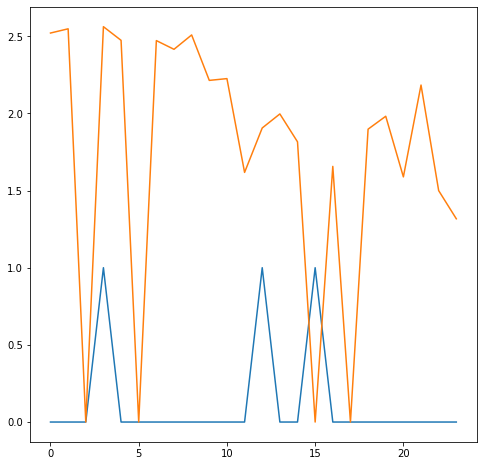

In [15]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.plot(test_labels.iloc[10,:])
axes.plot(preds_original[10])

In [ ]:
preds_original[10]

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.scatter(test_labels, preds_original[split_index:], 1, 'k')
diag = np.linspace(test_labels.min(), test_labels.max(), 10)
axes.plot(diag, diag, 'b--' )
axes.set_title(test_labels.columns[0])
plt.savefig("results/error_hist_fft.png", dpi=200, bbox_inches="tight")
# for a, ax in enumerate(axes.ravel()):
    

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.hist( (preds_original[split_index:] - test_labels.values)/ (test_labels.values.max() - test_labels.values.min()) ,
           bins=20)
axes.set_yscale("log")
axes.set_xlabel("Error in "+test_labels.columns[0])
plt.savefig("results/relative_error_histogram_fft.png", dpi=200, bbox_inches="tight")

In [ ]:
np.mean(np.abs(preds_original[split_index:] - test_labels.values), axis=0)

In [ ]:
np.mean(np.abs(preds_out[split_index:] - scaled_test_labels.values), axis=0)

In [ ]:
test_labels["d"].max()

In [ ]:
ds["xsize"]